# Model Training

## Importing Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy import stats

# Variables and Functions

In [14]:
root_dir = f"{os.getcwd()}/data"
input_dataset = f"{root_dir}/features.csv"
input_dataset2 = f"{root_dir}/features.csv"
# input_dataset2 = f"{root_dir}/features6.csv"
# input_dataset = f"{root_dir}/features-dash-v1.csv"
output_tree = f"{root_dir}/models/tree.txt"

In [15]:
def removeAtributoscomMesmoValor(dataset):

    dataset.drop(columns=dataset.columns[dataset.nunique()==1], inplace=True)

    return dataset

In [16]:
def removeOutliers(dataset):

    # detect and remove outliers
    z_scores = stats.zscore(dataset)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 5).all(axis=1)
    dataset = dataset[filtered_entries]
    # reset index
    #dataset = dataset.reset_index(drop=True)

    return dataset

In [17]:
def removeDadosFaltantes(dataset):

    dataset=dataset.dropna()
    return dataset

In [18]:
def normalization(X):

    scaler = sk.preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    return X

In [19]:
def test_model(model, X, y, plot_matrix=False):
  y_pred = model.predict(X)

  accuracy = accuracy_score(y, y_pred)
  precision = precision_score(y, y_pred, average="weighted")
  recall = recall_score(y, y_pred, average="weighted")
  f1 = f1_score(y, y_pred, average="weighted")

  cm = confusion_matrix(y, y_pred)

  # Display metrics
  print("\n" + "="*50)
  print("MODEL PERFORMANCE METRICS")
  print("="*50)
  print(f"Accuracy:  {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall:    {recall:.4f}")
  print(f"F1-Score:  {f1:.4f}")

  print("\n" + "="*50)
  print("DETAILED CLASSIFICATION REPORT")
  print("="*50)
  print(classification_report(y, y_pred))

  print("\n" + "="*50)
  print("CONFUSION MATRIX")
  print("="*50)
  print(cm)

  # Feature importance
  feature_importance = pd.DataFrame({
      'feature': X.columns,
      'importance': model.feature_importances_
  }).sort_values('importance', ascending=False)

  print("\n" + "="*50)
  print("FEATURE IMPORTANCE")
  print("="*50)
  print(feature_importance)

  if plot_matrix:
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y),
                yticklabels=np.unique(y))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
def import_csv(file, show_info=False):
  data = pd.read_csv(file)

  # data.dropna(subset=["flags"], inplace=True)

  # data = removeAtributoscomMesmoValor(data)
  data = removeDadosFaltantes(data)
  # data["IPI"] = removeOutliers(data["IPI"])

  if show_info:
    print("Info:")
    data.info()
    print("\nDescrição estatística:")
    print(data.describe())
    print("\nValores nulos:")
    print(data.isnull().sum())
    print("\nDistribuição da target:")
    print(data['classification'].value_counts())
    # print(data["Flags"].value_counts())

  return data

## Importing data

In [21]:
data = import_csv(input_dataset, True)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260374 entries, 0 to 260373
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   flow_key        260374 non-null  int64 
 1   srcip           260374 non-null  object
 2   dstip           260374 non-null  object
 3   sport           260374 non-null  int64 
 4   dport           260374 non-null  int64 
 5   proto           260374 non-null  int64 
 6   version         260374 non-null  int64 
 7   ihl             260374 non-null  int64 
 8   tos             260374 non-null  int64 
 9   length          260374 non-null  int64 
 10  id              260374 non-null  int64 
 11  frag            260374 non-null  int64 
 12  ttl             260374 non-null  int64 
 13  chksum          260374 non-null  int64 
 14  seq             260374 non-null  int64 
 15  ack             260374 non-null  int64 
 16  window          260374 non-null  int64 
 17  dataofs         260374 

In [22]:
data2 = import_csv(input_dataset2, True)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260374 entries, 0 to 260373
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   flow_key        260374 non-null  int64 
 1   srcip           260374 non-null  object
 2   dstip           260374 non-null  object
 3   sport           260374 non-null  int64 
 4   dport           260374 non-null  int64 
 5   proto           260374 non-null  int64 
 6   version         260374 non-null  int64 
 7   ihl             260374 non-null  int64 
 8   tos             260374 non-null  int64 
 9   length          260374 non-null  int64 
 10  id              260374 non-null  int64 
 11  frag            260374 non-null  int64 
 12  ttl             260374 non-null  int64 
 13  chksum          260374 non-null  int64 
 14  seq             260374 non-null  int64 
 15  ack             260374 non-null  int64 
 16  window          260374 non-null  int64 
 17  dataofs         260374 

# Training with best feature pair

In [23]:
from itertools import combinations

all_features = [
    # 'sport',
    # 'dport',
    'tos',
    # 'length',
    # 'id',
    # 'ttl',
    'frame_size',
    # 'chksum',
    # 'seq',
    # 'ack',
    'window',
    'ipi'
]

target = "classification"

X = data[all_features]
y = data[target]
X2 = data2[all_features]
y2 = data2[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=64,# stratify=y
)

max_depth=10

current_features = []

model_pair = DecisionTreeClassifier(random_state=64, max_depth=max_depth)

for i in range(5):
  feature_pairs = list(combinations(all_features, 2))
  print(f"Generated {len(feature_pairs)} unique feature pairs.")

  best_accuracy = 0
  best_validation = 0
  best_feature_pair = None

  for pair in feature_pairs:
      X_train_pair = X_train[current_features + list(pair)]
      X_test_pair = X_test[current_features + list(pair)]
      X2_pair = X2[current_features + list(pair)]

      model_pair.fit(X_train_pair, y_train)

      y_pred_pair = model_pair.predict(X_test_pair)
      y2_pred_pair = model_pair.predict(X2_pair)

      accuracy_pair = accuracy_score(y_test, y_pred_pair)
      accuracy2_pair = accuracy_score(y2, y2_pred_pair)

      # accuracy_pair = recall_score(y_test, y_pred_pair, average=None)[1]
      # accuracy2_pair = recall_score(y2, y2_pred_pair, average=None)[1]

      if accuracy_pair > best_accuracy:
          best_accuracy = accuracy_pair
          best_feature_pair = pair
          best_validation = accuracy2_pair




  # Add the best feature pair to the current features list
  current_features.append(best_feature_pair[0])
  current_features.append(best_feature_pair[1])

  # Remove best feature pair from the all_features list
  all_features.remove(best_feature_pair[0])
  all_features.remove(best_feature_pair[1])

  print(f"Current execution: {i+1}")
  print(f"Current features: {current_features}")
  print(f"Best feature pair: {best_feature_pair}")
  print(f"Highest accuracy achieved: {best_accuracy:.4f}")
  print(f"Highest accuracy achieved on validation: {best_validation:.4f}")
  print(f"Remaining features: {all_features}")
  print("="*50)

Generated 6 unique feature pairs.
Current execution: 1
Current features: ['tos', 'frame_size']
Best feature pair: ('tos', 'frame_size')
Highest accuracy achieved: 1.0000
Highest accuracy achieved on validation: 1.0000
Remaining features: ['window', 'ipi']
Generated 1 unique feature pairs.
Current execution: 2
Current features: ['tos', 'frame_size', 'window', 'ipi']
Best feature pair: ('window', 'ipi')
Highest accuracy achieved: 1.0000
Highest accuracy achieved on validation: 1.0000
Remaining features: []
Generated 0 unique feature pairs.


TypeError: 'NoneType' object is not subscriptable

In [ ]:
features = [
# "sport"         ,
# "dport"         ,
"tos"           ,
# "length"        ,
# "id"            ,
# "ttl"           ,
# "frame_size"    ,
# "chksum"        ,
# "seq"           ,
# "ack"           ,
"window"        ,
# "ipi"           ,
# "dataofs"       ,
# "urgptr"        ,
# "reserved"      ,
# "tcp_chk"       ,
# "proto"         ,
# "version"       ,
# "frag"          ,
# "ihl"           ,
#  "classification",
]

max_depth=10

class_names = [
    "nao_video",
    "video",
]

target = "classification"

X = data[features]
y = data[target]
X2 = data2[features]
y2 = data2[target]

# Model Training

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,# stratify=y
)

model = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

## Model testing

### 80 Tranining dataset

/home/icaro/Code/repo/In-NetworkML/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



MODEL PERFORMANCE METRICS
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    208299

    accuracy                           1.00    208299
   macro avg       1.00      1.00      1.00    208299
weighted avg       1.00      1.00      1.00    208299


CONFUSION MATRIX
[[208299]]

FEATURE IMPORTANCE
      feature  importance
0         tos         0.0
1  frame_size         0.0
2      window         0.0
3         ipi         0.0


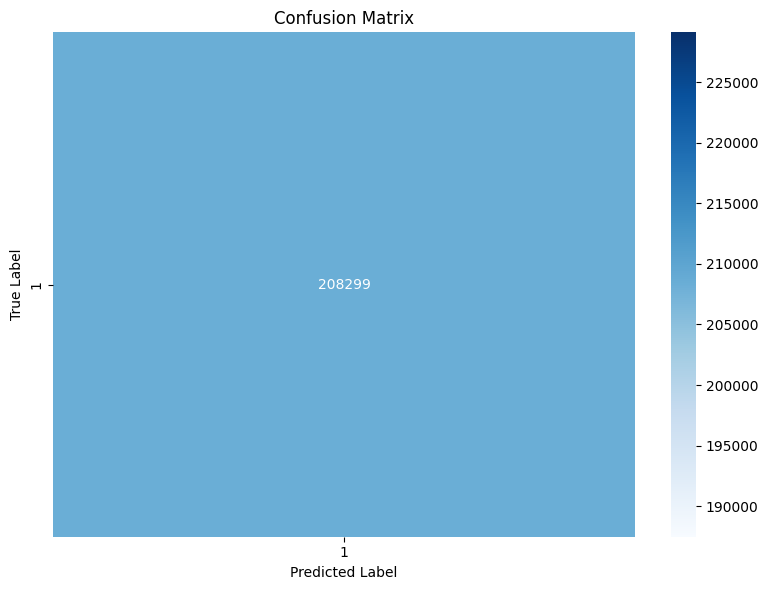

In [27]:
test_model(model, X_train, y_train, True)

### 20 Validation dataset

/home/icaro/Code/repo/In-NetworkML/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



MODEL PERFORMANCE METRICS
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     52075

    accuracy                           1.00     52075
   macro avg       1.00      1.00      1.00     52075
weighted avg       1.00      1.00      1.00     52075


CONFUSION MATRIX
[[52075]]

FEATURE IMPORTANCE
      feature  importance
0         tos         0.0
1  frame_size         0.0
2      window         0.0
3         ipi         0.0


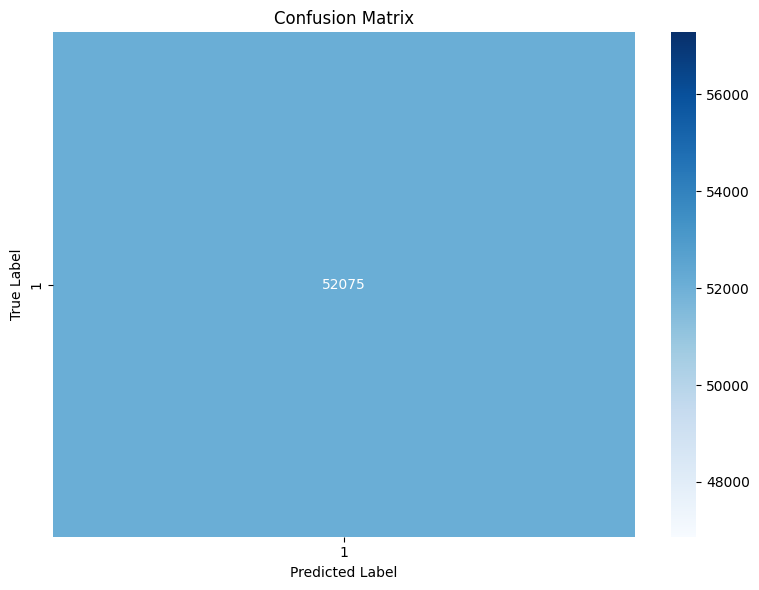

In [28]:
test_model(model, X_test, y_test, True)

### Testing dataset

/home/icaro/Code/repo/In-NetworkML/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



MODEL PERFORMANCE METRICS
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    260374

    accuracy                           1.00    260374
   macro avg       1.00      1.00      1.00    260374
weighted avg       1.00      1.00      1.00    260374


CONFUSION MATRIX
[[260374]]

FEATURE IMPORTANCE
      feature  importance
0         tos         0.0
1  frame_size         0.0
2      window         0.0
3         ipi         0.0


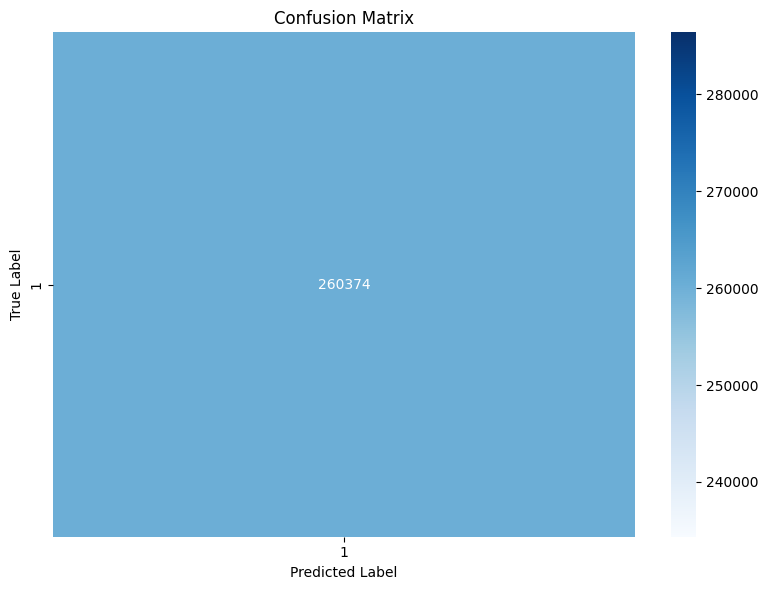

In [29]:
test_model(model, X2, y2, True)

# Model Exporting

In [30]:
from sklearn.tree import _tree
from datetime import datetime
import pickle

def exportar_regras_modelo(
    modelo: DecisionTreeClassifier,
    features: list[str],
    class_names: list[str],
    ):

  def _add_value(table, key, value):
    # value = int(new_value)
    if key not in table:
      table[key] = []
      table[key].append(value)
      return

    if value not in table[key]:
      table[key].append(value)

  res = {}

  regras = []

  def _recursive(node, conditions):
    if modelo.tree_.children_left[node] == _tree.TREE_LEAF:
      regras.append(f"when {' and '.join(conditions)} then {modelo.tree_.value[node].argmax()}")
      return

    feature = features[modelo.tree_.feature[node]]
    threshold = modelo.tree_.threshold[node]

    if feature == "ipi":
      threshold = int(threshold)
    else:
      threshold = int(threshold)

    _add_value(res, feature, threshold)

    left_conditions = conditions + [f"{feature}<={threshold}"]
    _recursive(modelo.tree_.children_left[node], left_conditions)

    right_conditions = conditions + [f"{feature}>{threshold}"]
    _recursive(modelo.tree_.children_right[node], right_conditions)

  _recursive(0, [])

  res["regras"] = regras

  for feature in features:
    try:
      res[feature] = sorted(res[feature])
    except:
      res[feature] = []

  return res

res = exportar_regras_modelo(model, features, class_names)

with open(output_tree, "w") as tree:
  for feature in features:
    tree.write(f"{feature} = {res[feature]};\n")
  for regra in res["regras"]:
    tree.write(f"{regra};\n")

for feature in features:
  print(f"{feature} = {res[feature]};")

for regra in res["regras"]:
  print(regra)

with open(f"{output_tree.replace('txt', 'pkl')}", "wb") as f:
  pickle.dump(model, f)

NameError: name 'features' is not defined

In [31]:
tree_rules = export_text(model, feature_names=features, class_names=class_names)

print(tree_rules)

NameError: name 'features' is not defined

In [32]:
from sklearn.tree import _tree

print(model.tree_.max_depth)
print(model.tree_.threshold)
print(_tree.TREE_UNDEFINED)
print(_tree.TREE_LEAF)
print(model.tree_.children_left)
print(model.tree_.children_right)
print(model.tree_.node_count)
print(model.tree_.feature)

0
[-2.]
-2
-1
[-1]
[-1]
1
[-2]


In [ ]:
import pickle

with open(f"{output_tree.replace('txt', 'pkl')}", "wb") as f:
  pickle.dump(model, f)

### Applying Undersampling to Training Data

I will use `RandomUnderSampler` to undersample the majority classes in the training data (`X_train`, `y_train`) to balance the dataset. This will help address the class imbalance issues observed earlier.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize RandomUnderSampler
# By default, it undersamples all majority classes to the number of samples in the minority class.
rus = RandomUnderSampler(random_state=42)

# Apply undersampling to the training data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled training set shape: {X_resampled.shape}, {y_resampled.shape}")
print("Distribution of classes in original training set:\n", y_train.value_counts())
print("Distribution of classes in resampled training set:\n", y_resampled.value_counts())

### Retraining Model with Undersampled Data

Now, I will retrain the Decision Tree model using the `X_resampled` and `y_resampled` data, which has a more balanced class distribution.

In [ ]:
# Retrain the Decision Tree model with the undersampled data
model_resampled = DecisionTreeClassifier(random_state=42, max_depth=3)
model_resampled.fit(X_resampled, y_resampled)

print("Model retraining complete with undersampled data.")

In [ ]:
test_model(model_resampled, X_test, y_test, True)

In [ ]:
y_pred = model_resampled.predict(X2)

accuracy = accuracy_score(y2, y_pred)
precision = precision_score(y2, y_pred, average="weighted")
recall = recall_score(y2, y_pred, average="weighted")
f1 = f1_score(y2, y_pred, average="weighted")

cm = confusion_matrix(y2, y_pred)

# Display metrics
print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y2, y_pred))

print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
print(cm)

# Hyperparametrization

In [ ]:
from sklearn.model_selection import KFold, RandomizedSearchCV
import numpy as np

# param_grid = {
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_leaf': [1, 5, 10, 20],
#     'criterion': ['gini', 'entropy']
# }

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

print("Hyperparameter grid defined:")
print(param_grid)

In [ ]:
from sklearn.model_selection import GridSearchCV

# grid_search = GridSearchCV(
#     estimator=DecisionTreeClassifier(random_state=42),
#     param_grid=param_grid,
#     scoring='f1_weighted',
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

cv = KFold(n_splits=5)

grid_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    # scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("GridSearchCV completed.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1-weighted score: {grid_search.best_score_:.4f}")

In [ ]:
best_model = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

print("New Decision Tree model trained with best hyperparameters.")

# Tests

In [ ]:
y_pred_tuned = best_model.predict(X_test)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned, average="weighted")
recall_tuned = recall_score(y_test, y_pred_tuned, average="weighted")
f1_tuned = f1_score(y_test, y_pred_tuned, average="weighted")

cm_tuned = confusion_matrix(y_test, y_pred_tuned)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS (TUNED MODEL)")
print("="*50)
print(f"Accuracy:  {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall:    {recall_tuned:.4f}")
print(f"F1-Score:  {f1_tuned:.4f}")

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT (TUNED MODEL)")
print("="*50)
print(classification_report(y_test, y_pred_tuned))

print("\n" + "="*50)
print("CONFUSION MATRIX (TUNED MODEL)")
print("="*50)
print(cm_tuned)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)
print(feature_importance)

In [ ]:
y_pred_tuned = best_model.predict(X2)

accuracy_tuned = accuracy_score(y2, y_pred_tuned)
precision_tuned = precision_score(y2, y_pred_tuned, average="weighted")
recall_tuned = recall_score(y2, y_pred_tuned, average="weighted")
f1_tuned = f1_score(y2, y_pred_tuned, average="weighted")

cm_tuned = confusion_matrix(y2, y_pred_tuned)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS (TUNED MODEL)")
print("="*50)
print(f"Accuracy:  {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall:    {recall_tuned:.4f}")
print(f"F1-Score:  {f1_tuned:.4f}")

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT (TUNED MODEL)")
print("="*50)
print(classification_report(y2, y_pred_tuned))

print("\n" + "="*50)
print("CONFUSION MATRIX (TUNED MODEL)")
print("="*50)
print(cm_tuned)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)
print(feature_importance)

In [ ]:
tree_rules = export_text(best_model, feature_names=features, class_names=class_names)

print(tree_rules)